In [1]:
from utils.utils import load_checkpoint, plot
from utils.dataset import *
import torch
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from pathlib import Path
model_path = Path('/root/trevor/syde770-project/best_models/lstm/17-04-2023_231059/')

In [101]:
valid_files_path = Path("/root/data/smartwatch/subjects_2023-07-05/")
train_files, val_files, test_files = get_file_lists(
    val_sub_list=['05', 10, 15, 20, 25, 30],
    test_sub_list=[10], # 
    valid_files_path=valid_files_path
)

BATCH_SIZE = 4
test_dataset = SmartwatchDataset(test_files)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=SmartwatchAugmentLstm(), drop_last=True, shuffle=False)

In [103]:
len(test_dataset), len(test_loader)

(18, 4)

In [29]:
from model.seq2seq_LSTM import Encoder, Decoder

encoder_model = Encoder(
    input_size=9,
    hidden_size=32,
    num_layers=1,
    dropout_p=0.1,
    channels=[9, 9],
    stride=2,
    kernel_size=32,
    downsample=True,
    seq_len=1024
).to("cpu")
decoder_model = Decoder(
    input_size=7,
    hidden_size=32,
    output_size=7,
    num_layers=1,
    dropout_p=0.1,
).to("cpu")

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [111]:
data = next(iter(test_loader))
data.keys()

dict_keys(['encoder_inputs', 'decoder_inputs', 'targets'])

In [113]:
train_target = data["targets"]
device = "cpu"

# Setup
decoder_output = torch.zeros(BATCH_SIZE, 512, 7).to(device)
encoder_inputs = data["encoder_inputs"]
decoder_inputs = data["decoder_inputs"]
decoder_inputs, seq_lens = torch.nn.utils.rnn.pad_packed_sequence(decoder_inputs, batch_first=True)

In [129]:
with torch.no_grad():
    encoder_hidden, encoder_cell = encoder_model(encoder_inputs)
    for b in range(BATCH_SIZE):
        # Run first step
        decoder_seed = decoder_inputs[b, 0, :].reshape((1, 7))
        initial_hidden = encoder_hidden[:, b, :]  # Shape (1, batch, hidden)??
        initial_cell = encoder_cell[:, b, :]
        output, (hidden, cell) = decoder_model.LSTM(decoder_seed, (initial_hidden, initial_cell))
        output = decoder_model.fc(output)
        decoder_output[b, 0, :] = output

        for i in range(1, seq_lens[b]):
            output, (hidden, cell) = decoder_model.LSTM(output, (hidden, cell))
            output = decoder_model.fc(output)
            decoder_output[b, i, :] = output

In [131]:
decoder_output.shape

torch.Size([4, 512, 7])

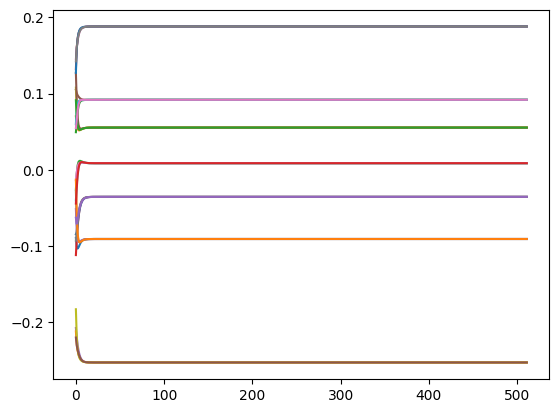

In [133]:
for b in range(BATCH_SIZE):
    plt.plot(decoder_output[b, :, :])
plt.show()